In [27]:
import numpy as np

def calculate_polarization_matrices(k_vec):
    """
    计算横波投影和偏振基底转换矩阵 A, B, M。
    
    参数:
        k_vec (np.ndarray): 归一化的波矢量 k = (kx, ky, kz)，模长 k=1。
        
    返回:
        M_proj (np.ndarray): 3x3 投影矩阵 M_proj = I - k * k.T
        A_mat (np.ndarray): 3x2 转换矩阵 (s, p -> x, y, z)
        B_mat (np.ndarray): 2x3 转换矩阵 (x, y, z -> s, p)
    """
    
    # 确保 k_vec 是归一化的 (k_vec.T * k_vec = 1)
    k_vec = k_vec / np.linalg.norm(k_vec)
    kx, ky, kz = k_vec
    
    # 1. 计算投影矩阵 M_proj (秩为 2 的投影算符)
    # M_proj = I - k * k.T
    I = np.eye(3)
    k_outer_k = np.outer(k_vec, k_vec) # k * k.T
    
    # 注意：您的原始矩阵形式是 M_proj = I - k*k.T，
    # 这里的 kx, ky, kz 应该是方向余弦，即 k^2=1。
    M_proj = I - k_outer_k
    
    # 2. 计算 s 和 p 偏振基底向量 (横波基底)
    k_rho_sq = kx**2 + ky**2
    
    if k_rho_sq < 1e-12:
        # 特殊情况：波沿 z 轴传播 (kx=0, ky=0, k_rho=0)
        # 此时 s-p 场的定义需要特殊处理。
        # 简单取 s = (0, 1, 0), p = (-1, 0, 0)
        s_vec = np.array([0.0, 1.0, 0.0])
        p_vec = np.array([-1.0, 0.0, 0.0])
    else:
        k_rho = np.sqrt(k_rho_sq)
        
        # s-偏振 (垂直于 k 和 z 轴张成的平面)
        # s ∝ k x z_hat = (-ky, kx, 0)
        s_vec = np.array([-ky, kx, 0.0]) / k_rho
        
        # p-偏振 (垂直于 k 和 s，位于入射平面内)
        # p ∝ k x s
        p_vec_unnorm = np.cross(k_vec, s_vec)
        p_vec = p_vec_unnorm / np.linalg.norm(p_vec_unnorm)
        
        # 另一种更简洁的 p_vec 形式（与上文公式一致，注意符号和归一化）
        # p_vec_check = np.array([kx*kz/k_rho, ky*kz/k_rho, -k_rho])
        
    # 3. 构造矩阵 A (3x2) 和 B (2x3)
    # A 的列是 s_vec 和 p_vec
    A_mat = np.column_stack((s_vec, p_vec))
    
    # B 是 A 的转置 (因为 s 和 p 是正交归一的)
    B_mat = A_mat.T
    
    return M_proj, A_mat, B_mat, s_vec, p_vec

def run_test(k_vec, E_vec):
    """
    运行测试，验证 A*B*E(r) 和 M*E(r) 的相等性。
    """
    print(f"--- 测试波矢量 k = {k_vec}")
    
    # 归一化波矢量
    k_norm = np.linalg.norm(k_vec)
    k_unit = k_vec / k_norm

    # 1. 计算矩阵
    M_proj, A_mat, B_mat, s_vec, p_vec = calculate_polarization_matrices(k_unit)
    
    # 2. 计算 A * B 的乘积（应等于 M_proj）
    A_B_mat = A_mat @ B_mat
    
    # 3. 计算两种投影结果
    # 方式 M: M_proj * E_vec
    E_proj_M = M_proj @ E_vec
    
    # 方式 A*B: A_mat * B_mat * E_vec
    E_proj_AB = A_B_mat @ E_vec
    
    # 4. 打印结果
    print("\n[矩阵结果]")
    print("M_proj 矩阵 (I - k*k.T):\n", np.round(M_proj, 4))
    print("\nA * B 矩阵 (A_mat @ B_mat):\n", np.round(A_B_mat, 4))
    
    print("\n[投影结果]")
    print(f"输入电场 E(0) = {E_vec}")
    print("结果 M*E(0) (笛卡尔投影)      :", np.round(E_proj_M, 6))
    print("结果 A*B*E(0) (S/P 转换投影)  :", np.round(E_proj_AB, 6))
    
    # 5. 验证相等性 (使用 numpy 的 allclose)
    is_equal = np.allclose(E_proj_M, E_proj_AB)
    print(f"\n验证 A*B*E(0) 和 M*E(0) 是否相等 (np.allclose): {is_equal}")
    
    # 6. 验证输入场 E(0) 的横波分量是否被保留
    E_dot_k = np.dot(E_vec, k_unit)
    E_proj_dot_k = np.dot(E_proj_M, k_unit)
    
    print(f"\n[横波条件检查]")
    print(f"输入场 E(0) 与 k 点乘 (E·k): {E_dot_k:.6f}")
    print(f"投影场 E_proj 与 k 点乘 (E_proj·k): {E_proj_dot_k:.6f} (应接近 0)")

    # 7. 验证 A*B 是否等于 M_proj (即验证投影矩阵的唯一性)
    is_matrix_equal = np.allclose(M_proj, A_B_mat)
    print(f"验证 A*B 和 M_proj 矩阵是否相等: {is_matrix_equal}")

    # 8. 验证 B*A 是否等于 2x2 单位矩阵
    B_A_mat = B_mat @ A_mat
    is_basis_equal = np.allclose(B_A_mat, np.eye(2))
    print(f"验证 B*A 是否等于 I_2x2 (s/p基底正交性): {is_basis_equal}")

    print("-" * 50)
    
# --- 运行测试用例 ---

# 测试 1: 斜入射波
# k = (1, 2, 3) 归一化后 kx, ky, kz 都在 0 附近
k_vec_1 = np.array([1.0, 2.0, 3.0])
k_vec_1 /= np.sqrt(np.sum(k_vec_1 * k_vec_1))
# 初始电场 E(0)，不一定满足横波条件
E_vec_1 = np.array([5.0, -1.0, 2.0]) 

run_test(k_vec_1, E_vec_1)


# 测试 2: 沿 x-y 平面传播 (kx=1, ky=0, kz=0，倏逝波情况)
k_vec_2 = np.array([1.0, 0.0, 0.0])
E_vec_2 = np.array([0.0, 3.0, 4.0]) # E(0) 满足 E·k=0 (3*0 + 4*0 = 0)

run_test(k_vec_2, E_vec_2)

--- 测试波矢量 k = [0.26726124 0.53452248 0.80178373]

[矩阵结果]
M_proj 矩阵 (I - k*k.T):
 [[ 0.9286 -0.1429 -0.2143]
 [-0.1429  0.7143 -0.4286]
 [-0.2143 -0.4286  0.3571]]

A * B 矩阵 (A_mat @ B_mat):
 [[ 0.9286 -0.1429 -0.2143]
 [-0.1429  0.7143 -0.4286]
 [-0.2143 -0.4286  0.3571]]

[投影结果]
输入电场 E(0) = [ 5. -1.  2.]
结果 M*E(0) (笛卡尔投影)      : [ 4.357143 -2.285714  0.071429]
结果 A*B*E(0) (S/P 转换投影)  : [ 4.357143 -2.285714  0.071429]

验证 A*B*E(0) 和 M*E(0) 是否相等 (np.allclose): True

[横波条件检查]
输入场 E(0) 与 k 点乘 (E·k): 2.405351
投影场 E_proj 与 k 点乘 (E_proj·k): 0.000000 (应接近 0)
验证 A*B 和 M_proj 矩阵是否相等: True
验证 B*A 是否等于 I_2x2 (s/p基底正交性): True
--------------------------------------------------
--- 测试波矢量 k = [1. 0. 0.]

[矩阵结果]
M_proj 矩阵 (I - k*k.T):
 [[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

A * B 矩阵 (A_mat @ B_mat):
 [[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

[投影结果]
输入电场 E(0) = [0. 3. 4.]
结果 M*E(0) (笛卡尔投影)      : [0. 3. 4.]
结果 A*B*E(0) (S/P 转换投影)  : [0. 3. 4.]

验证 A*B*E(0) 和 M*E(0) 是否相等 (np.allclose): True

[横波条件检查]
输入场 E(0

In [28]:
import numpy as np
from scipy.linalg import null_space

def calculate_projection_matrix(k_vec_input):
    """计算并返回归一化的波矢量和 M_proj 矩阵。"""
    k_norm = np.linalg.norm(k_vec_input)
    k_unit = k_vec_input / k_norm
    I = np.eye(3)
    M_proj = I - np.outer(k_unit, k_unit)
    return M_proj, k_unit

def calculate_eigenvectors_from_M(M_proj, k_unit):
    """
    根据 M_proj 矩阵和已知的特征值 (1, 1, 0) 计算特征向量 V1, V2, V3。
    """
    
    I = np.eye(3)
    
    # --- 1. 求解 V3 (特征值 lambda = 0) ---
    # 求解 (M - 0*I) * V3 = 0, 即 M * V3 = 0
    # V3 必须位于 M 的零空间 (Null Space) 中。
    
    # null_space 函数找到 M 矩阵的零空间基底。
    # 理论上，这个零空间应该只有一维，由 k_unit 张成。
    V3_candidates = null_space(M_proj)
    
    # 零空间函数返回的 V3 (可能需要调整方向使其与 k_unit 同向)
    if V3_candidates.shape[1] == 1:
        V3 = V3_candidates[:, 0]
        # 调整 V3 的方向，使其与 k_unit 同向
        if np.dot(V3, k_unit) < 0:
            V3 = -V3
    else:
        # 如果 M 矩阵计算精度不够，可能返回多个基，但理论上 V3 总是与 k_unit 共线
        V3 = k_unit
        
    # --- 2. 求解 V1 和 V2 (特征值 lambda = 1) ---
    # 求解 (M - 1*I) * V = 0, 即 (M - I) * V = 0
    # V1 和 V2 必须位于 (M - I) 的零空间中。
    
    # (M - I) = -k * k.T
    M_minus_I = M_proj - I
    
    # null_space 函数找到 (M - I) 矩阵的零空间基底。
    # 理论上，这个零空间是二维的，由 s 和 p 矢量张成。
    V1_V2_candidates = null_space(M_minus_I)
    
    # V1 和 V2 是这个二维零空间的两个正交基向量
    V1 = V1_V2_candidates[:, 0]
    V2 = V1_V2_candidates[:, 1]
    
    return V1, V2, V3

# --- 运行示例 ---

# 选择一个具体的波矢量 (非轴向)
k_vec_example = np.array([3.0, 4.0, 5.0]) 

# 1. 计算 M 矩阵和 k_unit
M_proj, k_unit = calculate_projection_matrix(k_vec_example)
kx, ky, kz = k_unit

print(f"--- 求解 k = {k_vec_example} 对应的特征向量 ---")
print(f"归一化波矢量 k_unit = {np.round(k_unit, 4)}")
print("\n投影矩阵 M_proj:\n", np.round(M_proj, 4))

# 2. 求解特征向量 V1, V2, V3
V1, V2, V3 = calculate_eigenvectors_from_M(M_proj, k_unit)

# 3. 打印结果
print("\n[求解结果]")
print(f"特征值 lambda=1 对应的特征向量 V1 (s-like): {np.round(V1, 6)}")
print(f"特征值 lambda=1 对应的特征向量 V2 (p-like): {np.round(V2, 6)}")
print(f"特征值 lambda=0 对应的特征向量 V3 (k-like): {np.round(V3, 6)}")


# 4. 验证 V1, V2, V3 的性质
print("\n[验证 V1, V2, V3 的性质]")

# 验证 V3 // k_unit
dot_V3_k = np.dot(V3, k_unit)
print(f"V3 · k_unit (应为 ±1): {dot_V3_k:.6f}")

# 验证 V1, V2 垂直于 k_unit (横波条件)
dot_V1_k = np.dot(V1, k_unit)
dot_V2_k = np.dot(V2, k_unit)
print(f"V1 · k_unit (应为 0): {dot_V1_k:.10f}")
print(f"V2 · k_unit (应为 0): {dot_V2_k:.10f}")

# 验证 V1, V2, V3 彼此正交
dot_V1_V2 = np.dot(V1, V2)
dot_V1_V3 = np.dot(V1, V3)
dot_V2_V3 = np.dot(V2, V3)
print(f"V1 · V2 (应为 0): {dot_V1_V2:.10f}")
print(f"V1 · V3 (应为 0): {dot_V1_V3:.10f}")
print(f"V2 · V3 (应为 0): {dot_V2_V3:.10f}")

# 验证 M * V = lambda * V
M_V1 = M_proj @ V1
M_V3 = M_proj @ V3
print(f"\n验证 M * V1 ≈ 1 * V1: {np.allclose(M_V1, V1)}")
print(f"验证 M * V3 ≈ 0 * V3: {np.allclose(M_V3, np.zeros(3))}")

--- 求解 k = [3. 4. 5.] 对应的特征向量 ---
归一化波矢量 k_unit = [0.4243 0.5657 0.7071]

投影矩阵 M_proj:
 [[ 0.82 -0.24 -0.3 ]
 [-0.24  0.68 -0.4 ]
 [-0.3  -0.4   0.5 ]]

[求解结果]
特征值 lambda=1 对应的特征向量 V1 (s-like): [-0.706526 -0.281642  0.649229]
特征值 lambda=1 对应的特征向量 V2 (p-like): [ 0.56641  -0.775034  0.280181]
特征值 lambda=0 对应的特征向量 V3 (k-like): [0.424264 0.565685 0.707107]

[验证 V1, V2, V3 的性质]
V3 · k_unit (应为 ±1): 1.000000
V1 · k_unit (应为 0): -0.0000000000
V2 · k_unit (应为 0): 0.0000000000
V1 · V2 (应为 0): -0.0000000000
V1 · V3 (应为 0): -0.0000000000
V2 · V3 (应为 0): -0.0000000000

验证 M * V1 ≈ 1 * V1: True
验证 M * V3 ≈ 0 * V3: True


In [29]:
import numpy as np

def calculate_projection_matrix(k_vec):
    """
    计算并返回 3x3 投影矩阵 M_proj = I - k * k.T。
    """
    k_vec = k_vec / np.linalg.norm(k_vec)
    I = np.eye(3)
    k_outer_k = np.outer(k_vec, k_vec)
    M_proj = I - k_outer_k
    return M_proj, k_vec

def analyze_matrix_M(k_vec_input):
    """
    对投影矩阵 M_proj 进行特征值分解，并验证其特性。
    
    参数:
        k_vec_input (np.ndarray): 波矢量 k。
    """
    print(f"--- 矩阵 M 特征值分解分析：k = {k_vec_input}")

    # 1. 计算 M 矩阵
    M_proj, k_unit = calculate_projection_matrix(k_vec_input)
    print("\n投影矩阵 M_proj (I - k*k.T):\n", np.round(M_proj, 4))

    # 2. 执行特征值分解
    # np.linalg.eig 返回特征值 (eigenvalues) 和特征向量 (eigenvectors)
    eigenvalues, eigenvectors = np.linalg.eig(M_proj)

    # 3. 排序 (通常按特征值的绝对值降序排列，有助于识别 0)
    idx = eigenvalues.argsort()[::-1] # 降序索引
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]

    print("\n[特征值分解结果]")
    print("排序后的特征值 (a, b, 0):", np.round(sorted_eigenvalues, 10))
    print("对应特征向量 V1, V2, V3 (按列排列):\n", np.round(sorted_eigenvectors, 4))

    # 4. 验证推论

    # 验证特征值
    lambda1, lambda2, lambda3 = sorted_eigenvalues
    print(f"\n验证特征值是否为 (1, 1, 0):")
    is_1_1_0 = np.allclose(sorted_eigenvalues[:2], 1.0) and np.allclose(sorted_eigenvalues[2], 0.0)
    print(f"  特征值接近 (1, 1, 0)?: {is_1_1_0}")
    
    # 验证零特征值对应的特征向量是否为 k (V3 = k)
    V3 = sorted_eigenvectors[:, 2]
    
    # 由于特征向量可以反向或乘以任意相位，我们比较 V3 和 k_unit 的共线性
    # 检查 V3 和 k_unit 的点乘的绝对值是否接近 1
    dot_product_V3_k = np.abs(np.dot(V3, k_unit))
    
    print("\n验证特征向量 V3 (对应特征值 0):")
    print(f"  V3 = {np.round(V3, 6)}")
    print(f"  k_unit = {np.round(k_unit, 6)}")
    print(f"  |V3 · k_unit| (共线性检查): {dot_product_V3_k:.6f} (应接近 1)")
    is_V3_k = np.allclose(dot_product_V3_k, 1.0)
    print(f"  V3 与 k_unit 平行?: {is_V3_k}")
    
    # 验证特征值 1 对应的特征向量是否为 s, p (V1, V2 垂直于 k)
    V1 = sorted_eigenvectors[:, 0]
    V2 = sorted_eigenvectors[:, 1]
    
    dot_product_V1_k = np.abs(np.dot(V1, k_unit))
    dot_product_V2_k = np.abs(np.dot(V2, k_unit))
    
    print("\n验证特征向量 V1, V2 (对应特征值 1):")
    print(f"  |V1 · k_unit| (横波检查): {dot_product_V1_k:.10f} (应接近 0)")
    print(f"  |V2 · k_unit| (横波检查): {dot_product_V2_k:.10f} (应接近 0)")
    is_V1_V2_transverse = np.allclose([dot_product_V1_k, dot_product_V2_k], 0.0)
    print(f"  V1 和 V2 垂直于 k?: {is_V1_V2_transverse}")


    assert(is_1_1_0 and is_V3_k and is_V1_V2_transverse)

    M,A,B,S,P = calculate_polarization_matrices(k_unit)
    print(f"s={S}, p={P}")
    print(f"v1={V1} v2={V2}, lambda=", lambda1, lambda2, lambda3)

    print("-" * 50)

# --- 运行测试用例 ---

# 测试 1: 斜入射波
k_vec_1 = np.array([3.0, 4.0, 5.0])
analyze_matrix_M(k_vec_1)

# # 测试 2: 沿着 y-z 平面传播 (k 矢量在 x=0)
# k_vec_2 = np.array([0.0, 4.0, 3.0])
# analyze_matrix_M(k_vec_2)

# # 测试 3: 沿 z 轴传播 (kx=0, ky=0)
# k_vec_3 = np.array([0.0, 0.0, 1.0])
# analyze_matrix_M(k_vec_3)

--- 矩阵 M 特征值分解分析：k = [3. 4. 5.]

投影矩阵 M_proj (I - k*k.T):
 [[ 0.82 -0.24 -0.3 ]
 [-0.24  0.68 -0.4 ]
 [-0.3  -0.4   0.5 ]]

[特征值分解结果]
排序后的特征值 (a, b, 0): [1. 1. 0.]
对应特征向量 V1, V2, V3 (按列排列):
 [[-0.8099 -0.     -0.4243]
 [-0.1122  0.7809 -0.5657]
 [ 0.5757 -0.6247 -0.7071]]

验证特征值是否为 (1, 1, 0):
  特征值接近 (1, 1, 0)?: True

验证特征向量 V3 (对应特征值 0):
  V3 = [-0.424264 -0.565685 -0.707107]
  k_unit = [0.424264 0.565685 0.707107]
  |V3 · k_unit| (共线性检查): 1.000000 (应接近 1)
  V3 与 k_unit 平行?: True

验证特征向量 V1, V2 (对应特征值 1):
  |V1 · k_unit| (横波检查): 0.0000000000 (应接近 0)
  |V2 · k_unit| (横波检查): 0.0000000000 (应接近 0)
  V1 和 V2 垂直于 k?: True
s=[-0.8  0.6  0. ], p=[-0.42426407 -0.56568542  0.70710678]
v1=[-0.80993827 -0.11216004  0.575691  ] v2=[-2.22715942e-16  7.80868809e-01 -6.24695048e-01], lambda= 1.0 0.9999999999999998 6.3294232510596784e-18
--------------------------------------------------


In [30]:
import numpy as np
from scipy.optimize import minimize

def calculate_projection_matrix(k_vec_input):
    """计算 M_proj 矩阵和归一化的 k 矢量。"""
    k_norm = np.linalg.norm(k_vec_input)
    k_unit = k_vec_input / k_norm
    I = np.eye(3)
    M_proj = I - np.outer(k_unit, k_unit)
    return M_proj, k_unit

def objective_function(V, M_minus_I):
    """目标函数：最小化 (M - I)V 的 L2 范数平方。"""
    # V 应该是 (M - I) 的零空间中的向量，因此 M_minus_I @ V 应该接近 0
    return np.sum((M_minus_I @ V)**2)

def constraint_norm(V):
    """约束 g1: 向量 V 必须归一化 (V^T V - 1 = 0)。"""
    return np.dot(V, V) - 1.0

def constraint_s_polarization(V):
    """约束 g2: S-偏振 V[2] 必须在 XY 平面内 (V[2] = 0)。"""
    # 确保 V 的第三个分量 (V[2]) 接近 0
    return V[2] # 目标是 V[2] = 0

def solve_with_kkt_constraints(k_vec_input):
    """
    使用约束优化 (KKT/SLSQP) 求解满足物理约束的特征向量 V1 (s-hat)。
    """
    print(f"--- 使用 KKT 约束优化求解 V1 (s-hat) ---")
    
    # 1. 准备矩阵 M 和 k_unit
    M_proj, k_unit = calculate_projection_matrix(k_vec_input)
    M_minus_I = M_proj - np.eye(3)
    
    # 2. 定义约束
    constraints = [
        {'type': 'eq', 'fun': constraint_norm, 'jac': lambda V: 2 * V},
        {'type': 'eq', 'fun': constraint_s_polarization, 'jac': lambda V: np.array([0.0, 0.0, 1.0])}
    ]
    
    # 3. 初始猜测 (接近期望值，但允许优化器调整)
    # 我们知道 V1 在 XY 平面内且垂直于 (kx, ky)，因此 V1 ~ (-ky, kx, 0)
    kx, ky, _ = k_unit
    initial_guess = np.array([-ky, kx, 0.0])
    
    # 归一化初始猜测，因为约束要求 V^T V = 1
    if np.linalg.norm(initial_guess) > 1e-6:
         V0 = initial_guess / np.linalg.norm(initial_guess)
    else: # 沿 Z 轴传播
         V0 = np.array([1.0, 0.0, 0.0]) 

    print(f"初始猜测 V0 (基于几何): {np.round(V0, 6)}")

    # 4. 执行约束优化
    # 'SLSQP' 是支持等式约束的常见方法
    result = minimize(
        objective_function, 
        V0, 
        args=(M_minus_I,), 
        method='SLSQP', 
        constraints=constraints,
        options={'disp': True, 'ftol': 1e-9}
    )

    # 5. 提取结果
    V1_s_hat = result.x
    
    # 6. 求解 V2 (p_hat) 和 V3 (k_unit)
    V3_k_unit = k_unit
    V2_p_hat = np.cross(V3_k_unit, V1_s_hat) # 保证正交性
    
    print("\n[KKT 优化结果]")
    print(f"优化后的目标函数值 (应接近 0): {result.fun:.10f}")
    print(f"V1 (s-hat) [KKT]: {np.round(V1_s_hat, 6)}")
    print(f"V2 (p-hat) [几何]: {np.round(V2_p_hat, 6)}")
    print(f"V3 (k-unit) [已知]: {np.round(V3_k_unit, 6)}")

    # 7. 验证
    print("\n[验证 KKT 约束]")
    print(f"V1[2] 约束 (应接近 0): {V1_s_hat[2]:.10f}")
    print(f"V1 归一化约束 (|V1|^2-1) (应接近 0): {constraint_norm(V1_s_hat):.10f}")
    print(f"特征值方程 M*V1 = 1*V1 (应接近 0): {np.linalg.norm(M_minus_I @ V1_s_hat):.10f}")
    
    # 8. 求解 V1 (V_a, V_b 零空间方法) 作为参考
    from scipy.linalg import null_space
    V_candidates = null_space(M_minus_I)
    
    # 验证 KKT 结果是否位于特征空间中
    is_in_feature_space = np.linalg.norm(M_minus_I @ V1_s_hat) < 1e-6
    print(f"KKT 结果是否在 M 的特征空间中 (误差 < 1e-6)? {is_in_feature_space}")
    
# --- 运行示例 ---
k_vec_example = np.array([3.0, 4.0, 5.0]) 
solve_with_kkt_constraints(k_vec_example)

print("\n" + "="*70 + "\n")

k_vec_example_2 = np.array([1.0, 0.0, 1.0]) # 另一个测试案例
solve_with_kkt_constraints(k_vec_example_2)


--- 使用 KKT 约束优化求解 V1 (s-hat) ---
初始猜测 V0 (基于几何): [-0.8  0.6  0. ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.162975822039155e-33
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

[KKT 优化结果]
优化后的目标函数值 (应接近 0): 0.0000000000
V1 (s-hat) [KKT]: [-0.8  0.6  0. ]
V2 (p-hat) [几何]: [-0.424264 -0.565685  0.707107]
V3 (k-unit) [已知]: [0.424264 0.565685 0.707107]

[验证 KKT 约束]
V1[2] 约束 (应接近 0): 0.0000000000
V1 归一化约束 (|V1|^2-1) (应接近 0): -0.0000000000
特征值方程 M*V1 = 1*V1 (应接近 0): 0.0000000000
KKT 结果是否在 M 的特征空间中 (误差 < 1e-6)? True


--- 使用 KKT 约束优化求解 V1 (s-hat) ---
初始猜测 V0 (基于几何): [-0.  1.  0.]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

[KKT 优化结果]
优化后的目标函数值 (应接近 0): 0.0000000000
V1 (s-hat) [KKT]: [-0.  1.  0.]
V2 (p-hat) [几何]: [-0.707107 -0.        0.707107]
V3 

In [31]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 全局列表，用于存储迭代历史
history = []

def callback_function(V):
    """
    minimize 在每次迭代后调用的回调函数。
    记录当前的目标函数值和迭代向量。
    """
    # 获取当前目标函数值
    current_fun_value = objective_function(V, M_minus_I_global)
    
    # 获取当前约束违反情况 (例如归一化约束)
    norm_violation = constraint_norm(V)
    s_pol_violation = constraint_s_polarization(V)
    
    # 记录数据
    history.append({
        'iteration': len(history),
        'fun_value': current_fun_value,
        'norm_violation': norm_violation,
        's_pol_violation': s_pol_violation,
        'V': np.copy(V) # 记录当前的向量 V
    })

# 定义全局变量以供回调函数访问（这是 Python 中常用但不太优雅的方法，但对于演示很实用）
M_minus_I_global = None

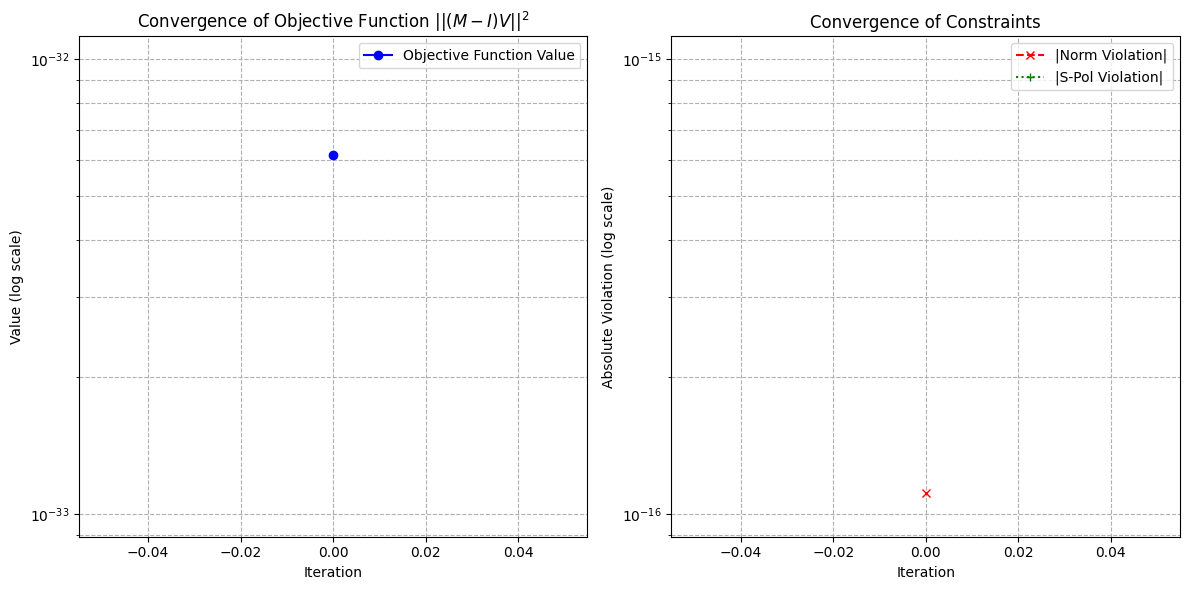

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.162975822039155e-33
       x: [-8.000e-01  6.000e-01  0.000e+00]
     nit: 1
     jac: [ 2.682e-09  4.768e-09  7.451e-09]
    nfev: 4
    njev: 1

In [32]:
# (省略 objective_function, constraint_norm, constraint_s_polarization 的定义)

def solve_and_plot_kkt(k_vec_input):
    global M_minus_I_global
    global history
    
    # 1. 准备矩阵 M
    M_proj, k_unit = calculate_projection_matrix(k_vec_input)
    M_minus_I = M_proj - np.eye(3)
    M_minus_I_global = M_minus_I # 赋值给全局变量

    # 2. 初始猜测 (与前文相同)
    kx, ky, _ = k_unit
    initial_guess = np.array([-ky, kx, 0.0])
    V0 = initial_guess / np.linalg.norm(initial_guess)
    
    # 3. 定义约束
    constraints = [
        {'type': 'eq', 'fun': constraint_norm},
        {'type': 'eq', 'fun': constraint_s_polarization}
    ]
    
    # 4. 重置历史记录并执行优化
    history = []
    
    # 注意：这里我们使用 callback 函数，并关闭 'disp' (详细输出) 避免干扰
    result = minimize(
        objective_function, 
        V0, 
        args=(M_minus_I,), 
        method='SLSQP', 
        constraints=constraints,
        callback=callback_function, # 传入回调函数
        options={'disp': False, 'ftol': 1e-9}
    )

    # 5. 绘制收敛曲线
    plot_convergence_curve()
    
    return result

def plot_convergence_curve():
    """绘制收敛曲线 (目标函数值和约束违反情况)。"""
    if not history:
        print("没有记录迭代历史。")
        return

    iterations = [d['iteration'] for d in history]
    fun_values = [d['fun_value'] for d in history]
    norm_violations = [np.abs(d['norm_violation']) for d in history]
    s_pol_violations = [np.abs(d['s_pol_violation']) for d in history]

    plt.figure(figsize=(12, 6))

    # --- 左图: 目标函数值 (收敛到零) ---
    plt.subplot(1, 2, 1)
    # 使用对数坐标观察收敛速度
    plt.plot(iterations, fun_values, marker='o', linestyle='-', color='blue', label='Objective Function Value')
    plt.yscale('log') # 目标值通常指数级下降，使用 log 更好观察
    plt.title('Convergence of Objective Function $||(M-I)V||^2$')
    plt.xlabel('Iteration')
    plt.ylabel('Value (log scale)')
    plt.grid(True, which="both", ls="--")
    plt.legend()

    # --- 右图: 约束违反情况 (收敛到零) ---
    plt.subplot(1, 2, 2)
    plt.plot(iterations, norm_violations, marker='x', linestyle='--', color='red', label='|Norm Violation|')
    plt.plot(iterations, s_pol_violations, marker='+', linestyle=':', color='green', label='|S-Pol Violation|')
    plt.yscale('log')
    plt.title('Convergence of Constraints')
    plt.xlabel('Iteration')
    plt.ylabel('Absolute Violation (log scale)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# --- 运行示例 ---
# 注意：你需要确保前面代码中的 objective_function, constraint_norm, 
# constraint_s_polarization, 和 calculate_projection_matrix 已经被定义或包含。

# 为了代码完整性，再次定义前面用到的核心函数
def calculate_projection_matrix(k_vec_input):
    k_norm = np.linalg.norm(k_vec_input)
    k_unit = k_vec_input / k_norm
    I = np.eye(3)
    M_proj = I - np.outer(k_unit, k_unit)
    return M_proj, k_unit

def objective_function(V, M_minus_I):
    return np.sum((M_minus_I @ V)**2)

def constraint_norm(V):
    return np.dot(V, V) - 1.0

def constraint_s_polarization(V):
    return V[2]


# 运行求解和绘图
k_vec_example = np.array([3.0, 4.0, 5.0]) 
solve_and_plot_kkt(k_vec_example)